<a href="https://colab.research.google.com/github/LH-1169213/Equipo3/blob/main/SVM_Equipo03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Maestría en Inteligencia Artificial Aplicada**
##**Curso: Inteligencia Artificial y Aprendizaje Automático**
###Tecnológico de Monterrey
###Prof Luis Eduardo Falcón Morales

## **Adtividad de la Semana 8**
###**Máquina de Vector Soporte - Support Vector Machine(SVM)**


**Nombres y matrículas de los integrantes del equipo:**

*   Samara García González A01273001
*   Laura Elena Hernández Mata A01169213
*   Evelyn Aylin Rendon Medina A01748750
*   Emmanuel González Calitl A01320739
*   Carlos Enrique Diaz Ayala A01793816

En cada sección deberás incluir todas las líneas de código necesarias para responder a cada uno de los ejercicios.

In [105]:
# Incluye aquí todos módulos, librerías y paquetes que requieras.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import power_transform

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import TransformedTargetRegressor

from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold 
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import  cross_validate
from sklearn.metrics import make_scorer

from sklearn.model_selection import learning_curve, validation_curve

import sklearn
from sklearn import svm
from sklearn.linear_model import LinearRegression #REALMENTE LA USAMOS??
from sklearn.ensemble import RandomForestRegressor #REALMENTE LA USAMOS??
from sklearn.neural_network import MLPRegressor #REALMENTE LA USAMOS??
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, roc_curve, RocCurveDisplay

from sklearn.dummy import DummyRegressor #REALMENTE LA USAMOS??
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance

from sklearn.linear_model import LogisticRegression #REALMENTE LA USAMOS??
from sklearn.tree import DecisionTreeClassifier #REALMENTE LA USAMOS??
from sklearn.ensemble import RandomForestClassifier #REALMENTE LA USAMOS??

from sklearn.metrics import recall_score #SÓLO PARA VALIDACIÓN
from sklearn.metrics import f1_score #SÓLO PARA VALIDACIÓN
from sklearn.metrics import make_scorer #SÓLO PARA VALIDACIÓN
from imblearn.metrics import geometric_mean_score #SÓLO PARA VALIDACIÓN
from sklearn.metrics import confusion_matrix #SÓLO PARA VALIDACIÓN


In [62]:
#Funciones de errores
def RMSEFunction(yReal, yEstimada):
  return np.sqrt(np.mean(np.square(yReal-yEstimada)))

def MAEFunction(yReal, yEstimada):
  return np.mean(np.abs(yReal-yEstimada)) 

def MAPEFunction(yReal, yEstimada):
  return np.mean(np.abs((yReal-yEstimada)/yReal))*100

In [63]:
#Funciones de métricas

#FUNCIÓN ACCURACY
def accuracyFunction(Yreal, Yestimada):
  vn, fp, fn, vp = confusion_matrix(Yreal, Yestimada).ravel()
  accuracy = (vp+vn)/(vp+vn+fp+fn+np.finfo(np.float32).eps)
  return accuracy
#FUNCION PRECISIÓN 
def precisionFunction(Yreal, Yestimada):
  vn, fp, fn, vp=confusion_matrix(Yreal, Yestimada).ravel()
  precision = vp / (vp+fp+np.finfo(np.float32).eps)
  return precision
#FUNCIÓN RECALL
def recallFunction(Yreal, Yestimada):
  vn, fp, fn, vp=confusion_matrix(Yreal, Yestimada).ravel()
  recall = vp / (vp+fn+np.finfo(np.float32).eps)
  return recall
#FUNCIÓN F1 SCORE
def f1Function(Yreal, Yestimada):
  vn, fp, fn, vp=confusion_matrix(Yreal, Yestimada).ravel()
  f1score = 2*vp / (2*vp+fp+fn+np.finfo(np.float32).eps)
  return f1score
#FUNCIÓN ESPECIFICIDAD
def especificidadFunction(Yreal, Yestimada):
  vn, fp, fn, vp=confusion_matrix(Yreal, Yestimada).ravel()
  especificidad = vn / (vn+fp+np.finfo(np.float32).eps)
  return especificidad
#FUNCIÓN GMEAN
def gmeanFunction(Yreal, Yestimada):
 vp, fp, fn, vp=confusion_matrix(Yreal, Yestimada).ravel()
 gmean = np.sqrt(recallFunction(Yreal, Yestimada) * especificidadFunction(Yreal, Yestimada))
 return gmean

#**Preparación del data frame:**

In [64]:
#Obtener el data set:

path = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/australian/australian.dat"
titles =  ['A1', 'A2','A3', 'A4','A5', 'A6','A7', 'A8','A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15']

datos_originales = pd.read_csv(path, sep = " ", names = titles)
datos_originales.head()


,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15
0,1,22.08,11.46,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,0,22.67,7.00,2,8,4,0.165,0,0,0,0,2,160,1,0
2,0,29.58,1.75,1,4,4,1.250,0,0,0,1,2,280,1,0
3,0,21.67,11.50,1,5,3,0.000,1,1,11,1,2,0,1,1
4,1,20.17,8.17,2,6,4,1.960,1,1,14,0,2,60,159,1


In [65]:
df = datos_originales

In [66]:
df.dtypes

A1       int64
A2     float64
A3     float64
A4       int64
A5       int64
A6       int64
A7     float64
A8       int64
A9       int64
A10      int64
A11      int64
A12      int64
A13      int64
A14      int64
A15      int64
dtype: object

Sin columnas tipo objeto.

In [67]:
#Remplazar signos de interrogación a Nan's:
df=df.replace('?',np.NaN)

In [68]:
#OBTENEMOS LA INFORMACIÓN DE NUESTRO DF
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A1      690 non-null    int64  
 1   A2      690 non-null    float64
 2   A3      690 non-null    float64
 3   A4      690 non-null    int64  
 4   A5      690 non-null    int64  
 5   A6      690 non-null    int64  
 6   A7      690 non-null    float64
 7   A8      690 non-null    int64  
 8   A9      690 non-null    int64  
 9   A10     690 non-null    int64  
 10  A11     690 non-null    int64  
 11  A12     690 non-null    int64  
 12  A13     690 non-null    int64  
 13  A14     690 non-null    int64  
 14  A15     690 non-null    int64  
dtypes: float64(3), int64(12)
memory usage: 81.0 KB


In [69]:
df.isna().any()

A1     False
A2     False
A3     False
A4     False
A5     False
A6     False
A7     False
A8     False
A9     False
A10    False
A11    False
A12    False
A13    False
A14    False
A15    False
dtype: bool

Sin valores Nan's

In [70]:
# DEFINICIÓN DE LAS VARIABLES

X = df.iloc[:,0:14] # VARIABLES DE ENTRADA

y = df["A15"] # VARIABLE DE SALIDA

#**Ejercicio-1.** 

Realiza una partición de los datos con 15% en el conjunto de prueba y el resto para entrenamiento y
validación. Usa un random_state=0. 


In [71]:
# Partición de datos:
#Datos totales 690, 15% -> 104 para prueba.

Xtrain, Xtest, Ytrain, Ytest =  train_test_split(X,y, test_size = 0.15, random_state = 0) 

# REVISAMOS QUE LA PARTICIÓN HAYA SIDO CORRECTA
print("Tamaño de las variables de entrada y salida sin partición (X & y)")
print(X.shape, y.shape)

print("Tamaño de los valores de entrenamiento (Xtrain & Ytrain)")
print(Xtrain.shape, Ytrain.shape)

print("Tamaño de los valores de prueba (Xtest & Ytest)")
print(Xtest.shape, Ytest.shape)

Tamaño de las variables de entrada y salida sin partición (X & y)
(690, 14) (690,)
Tamaño de los valores de entrenamiento (Xtrain & Ytrain)
(586, 14) (586,)
Tamaño de los valores de prueba (Xtest & Ytest)
(104, 14) (104,)


#**Ejercicio-2.**

 Hacer una análisis de los datos y llevar a cabo las transformaciones que consideres adecuadas.
Utiliza un Pipeline para evitar el filtrado de información. 

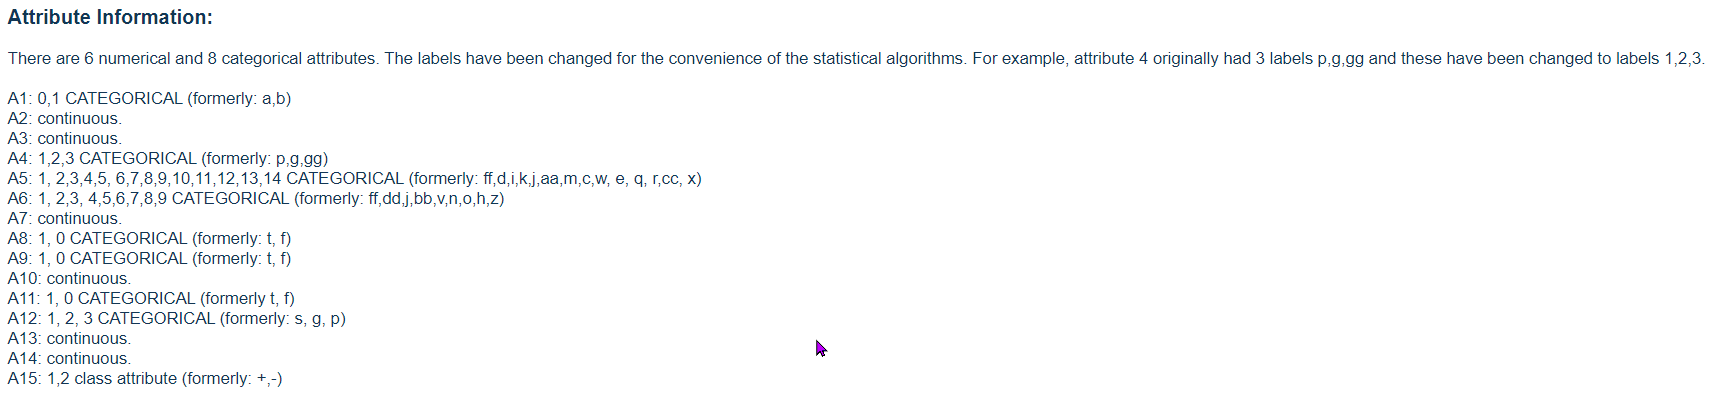

In [72]:
df.describe()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15
count,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.00000,690.000000,690.000000,690.000000,690.000000,690.000000
mean,0.678261,31.568203,4.758725,1.766667,7.372464,4.692754,2.223406,0.523188,0.427536,2.40000,0.457971,1.928986,184.014493,1018.385507,0.444928
std,0.467482,11.853273,4.978163,0.430063,3.683265,1.992316,3.346513,0.499824,0.495080,4.86294,0.498592,0.298813,172.159274,5210.102598,0.497318
min,0.000000,13.750000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,0.000000,22.670000,1.000000,2.000000,4.000000,4.000000,0.165000,0.000000,0.000000,0.00000,0.000000,2.000000,80.000000,1.000000,0.000000
50%,1.000000,28.625000,2.750000,2.000000,8.000000,4.000000,1.000000,1.000000,0.000000,0.00000,0.000000,2.000000,160.000000,6.000000,0.000000
75%,1.000000,37.707500,7.207500,2.000000,10.000000,5.000000,2.625000,1.000000,1.000000,3.00000,1.000000,2.000000,272.000000,396.500000,1.000000
max,1.000000,80.250000,28.000000,3.000000,14.000000,9.000000,28.500000,1.000000,1.000000,67.00000,1.000000,3.000000,2000.000000,100001.000000,1.000000


Los valores de variables catégoricas están dentro del rango, no es necesario corregir rangos.

In [73]:
# DIVISIÓN DE VARIABLES DE ENTRADA EN CATEGÓRICA, ORDINAL, NUMÉRICA Y BINARIA

categorical_vars = ['A4', 'A5', 'A6', 'A12'] #Variables categóricas
ordinal_vars = [] #Variables cuantitativas discretizadas
quantitative_vars = ['A2', 'A3', 'A7', 'A10', 'A13', 'A14'] #Variables numéricas
in_binary_vars = ['A1', 'A8', 'A9', 'A11'] #Variables binarias de entrada
out_binary_vars = ['A15'] #Variables binarias de salida

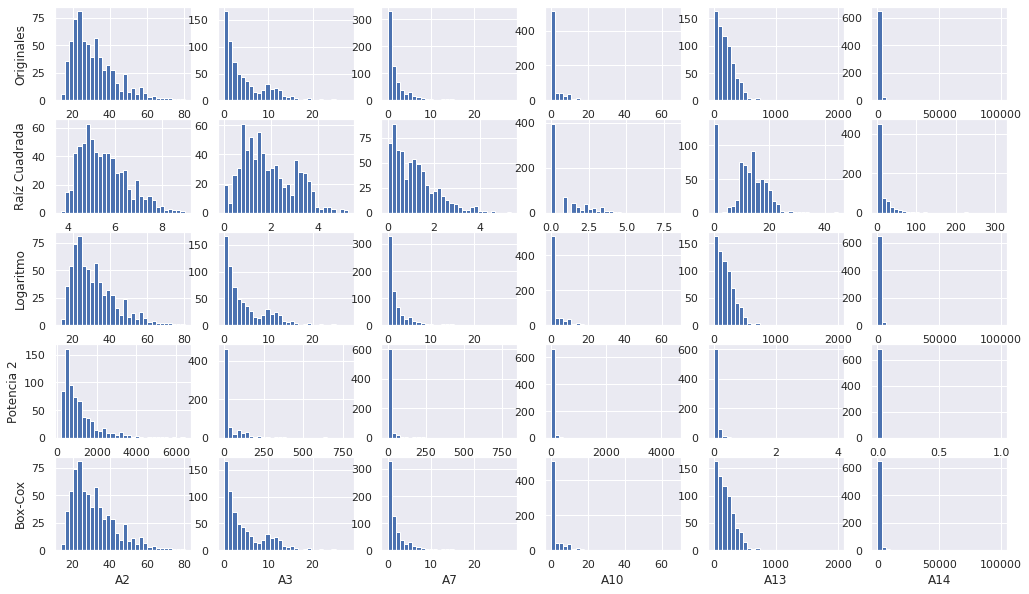

In [74]:
# CONOCIENDO EL COMPORTAMIENTO DE NUESTRAS VARIABLES

variables_a_transformar = quantitative_vars


sns.set(rc={'figure.figsize':(20,10)})
fig, axes = plt.subplots(5, 5)   

  
for k in range(0,6):       
 
    # Datos originales 
    plt.subplot(5,7,k+1) 

    Transf0 = df[variables_a_transformar[k]]          
    plt.hist(Transf0,bins=30)                               

    plt.xlabel(variables_a_transformar[k])
    if k==0:
      plt.ylabel('Originales')
    
    # Datos transformados con raíz cuadrada 
    plt.subplot(5,7,k+8)    

    Transf1 = np.sqrt(Transf0)          
    plt.hist(Transf1, bins=30)               

    plt.xlabel(variables_a_transformar[k])
    if k==0:
      plt.ylabel('Raíz Cuadrada')
      
    # Datos transformados con logaritmo natural 
    plt.subplot(5,7,k+15)     

    Transf2 =  Transf0  #np.log(Transf0) *************************************** <------------------------------------------ log(0) -infinite         
    plt.hist(Transf2,bins=30)          

    plt.xlabel(variables_a_transformar[k])
    if k==0:
      plt.ylabel('Logaritmo')
    
    # Datos transformados con la potencia de 2 
    plt.subplot(5,7,k+22)

    Transf3 = np.power(Transf0,2)          
    plt.hist(Transf3,bins=30)              

    plt.xlabel(variables_a_transformar[k])
    if k==0:
      plt.ylabel('Potencia 2')
    

    # Datos transformados con Box-Cox 
    plt.subplot(5,7,k+29)

    Transf4 = Transf0  #power_transform(Transf0.to_frame(),method="box-cox") #np.log(Transf0) ******** <------------------------------------------ Método box cox no acepta 0           
    plt.hist(Transf4,bins=30)                                               

    plt.xlabel(variables_a_transformar[k])
    if k==0:
      plt.ylabel('Box-Cox')


plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


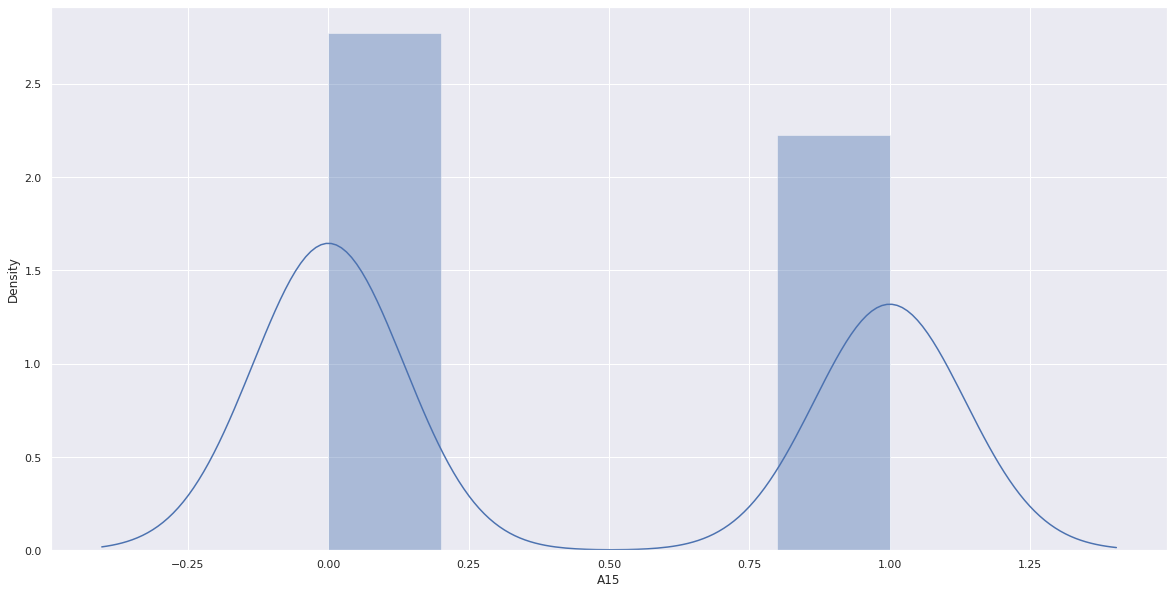

In [75]:
#
sns.distplot(df['A15'])

In [76]:
num_credits = df['A15'].value_counts()
num_credits

0    383
1    307
Name: A15, dtype: int64

Clases ligeramente desbalanceadas, se niegan más créditos de los que se entregan.

In [77]:
# PIPELINE, ESCALACIÓN DE DATOS CUANTITATIVOS CON EL MÉTODO DE MinMaxScaler,
quantitative_pipeline = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),('scaler',MinMaxScaler(feature_range=(1,2)))])
col_quantitative = quantitative_vars

# TRANSFORMACIÓN ONE HOT ENCODER PARA VARIABLES CATEGÓRICAS Y BINARIAS.
categorical_pipeline = Pipeline(steps = [("imputer", SimpleImputer(strategy='most_frequent')),('onehot',OneHotEncoder(handle_unknown="ignore"))])
col_categorical = categorical_vars

binary_pipeline = Pipeline(steps = [("imputer", SimpleImputer(strategy='most_frequent')),('onehot',OneHotEncoder(handle_unknown="ignore"))])
col_binary_in = in_binary_vars

#No se usan variables ordinals, se quita del cols transformer
#ordinal_pipeline = Pipeline(steps = [("imputer", SimpleImputer(strategy='most_frequent'))]) 
#col_ordinal = ordinal_vars

cols_Transformer = ColumnTransformer(transformers = [('quantitative', quantitative_pipeline, col_quantitative),
                                                        ('categorical', categorical_pipeline, col_categorical),
                                                        ('binary_in', binary_pipeline, col_binary_in), 
                                                        ], remainder='passthrough')


In [78]:
#REVISIÓN DE CONFIGURACIÓN
X_train_fit = cols_Transformer.fit(Xtrain)
print(X_train_fit)


ColumnTransformer(remainder='passthrough',
                  transformers=[('quantitative',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler',
                                                  MinMaxScaler(feature_range=(1,
                                                                              2)))]),
                                 ['A2', 'A3', 'A7', 'A10', 'A13', 'A14']),
                                ('categorical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['A4', 'A5', 'A6', 'A12']),
                                ('binary_in',
                                 Pipeline(steps=[('imputer',
     

#**Ejercicio-3.**

Utiliza la función Dummy para modelos de clasificación con la estrategia “stratified” con el conjunto
que tienes de datos de entrenamiento y validación. Obtener los valores de partida (baseline) de las 
siguientes métricas: accuracy, f1-score, precision y recall. ¿Por qué consideras que es adecuado usar
la estrategia “stratified” en este caso? 

 

In [79]:
# HACEMOS LA PARTICIÓN DE LOS DATOS TOMANDO COMO BASE LOS DATOS DE ENTRENAMIENTO Y VALIDACIÓN (Xtrain, Ytrain)
# QUE ESTABLECIMOS PREVIAMENTE

Xtrain2, Xval, Ytrain2, Yval = train_test_split(Xtrain, Ytrain, train_size = 410, test_size = 176, random_state = 0)

# REVISAMOS QUE LA PARTICIÓN HAYA SIDO CORRECTA
print("Tamaño de las variables de entrada y salida sin partición (X & y)")
print(X.shape, y.shape)

print("\n------Partición del Ejercicio 1:------")

print("Tamaño de los valores de entrenamiento (Xtrain & Ytrain)")
print(Xtrain.shape, Ytrain.shape)

print("Tamaño de los valores de prueba (Xtest & Ytest)")
print(Xtest.shape, Ytest.shape)


print("\n------Partición actual:------")

print("Tamaño de los valores de entrenamiento actuales (Xtrain2 & Ytrain2)")
print(Xtrain2.shape, Ytrain2.shape)

print("Tamaño de los valores de validación (Xval & Yval)")
print(Xval.shape, Yval.shape)

Tamaño de las variables de entrada y salida sin partición (X & y)
(690, 14) (690,)

------Partición del Ejercicio 1:------
Tamaño de los valores de entrenamiento (Xtrain & Ytrain)
(586, 14) (586,)
Tamaño de los valores de prueba (Xtest & Ytest)
(104, 14) (104,)

------Partición actual:------
Tamaño de los valores de entrenamiento actuales (Xtrain2 & Ytrain2)
(410, 14) (410,)
Tamaño de los valores de validación (Xval & Yval)
(176, 14) (176,)


Doku:

A dummy classifier is a type of classifier which does not generate any insight about the data and classifies the given data using only simple rules. The classifier’s behavior is completely independent of the training data as the trends in the training data are completely ignored and instead uses one of the strategies to predict the class label.

It is used only as a simple baseline for the other classifiers i.e. any other classifier is expected to perform better on the given dataset. It is especially useful for datasets where are sure of a class imbalance. It is based on the philosophy that any analytic approach for a classification problem should be better than a random guessing approach.

Below are a few strategies used by the dummy classifier to predict a class label –


***Stratified:*** It generates predictions by respecting the class distribution of the training data. It is different from the “most frequent” strategy as it instead associates a probability with each data point of being the most frequent class label.s.

In [80]:
dummy_clf = DummyClassifier(strategy = "stratified") #Estrategia solicitada en las instrucciones del ejercicio

dummy_clf.fit(Xtrain2, Ytrain2)             #Datos de entrenamiento y validación de la partición anterior

print("Accuracy from Dummy Classifier Validación (Baseline):\n")
dummy_clf.score(Xval, Yval)             # Valores de partida (baseline) de entrenamiento y validación


Accuracy from Dummy Classifier Validación (Baseline):



0.4375

In [81]:
dummy_clf = DummyClassifier(strategy = "stratified") #Estrategia solicitada en las instrucciones del ejercicio

dummy_clf.fit(Xtrain2, Ytrain2)

Ytrain2_hat = dummy_clf.predict(Xtrain2)
Ytest2_hat = dummy_clf.predict(Xval)

print("\n------Resultados de métricas:------")
print("\nAccuracy entrenamiento:", accuracyFunction(Ytrain2.values, Ytrain2_hat))
print("Accuracy validación:", accuracyFunction(Yval.values, Ytest2_hat))
#f1-score, precision y recall
print("\nf1-score entrenamiento:", f1Function(Ytrain2.values, Ytrain2_hat))
print("f1-score validación:", f1Function(Yval.values, Ytest2_hat))
print("\nPrecision entrenamiento:", precisionFunction(Ytrain2.values, Ytrain2_hat))
print("Precision validación:", precisionFunction(Yval.values, Ytest2_hat))
print("\nRecall entrenamiento:", recallFunction(Ytrain2.values, Ytrain2_hat))
print("Recall validación:", recallFunction(Yval.values, Ytest2_hat))


------Resultados de métricas:------

Accuracy entrenamiento: 0.5243902437499702
Accuracy validación: 0.5170454541952465

f1-score entrenamiento: 0.47154471529481706
f1-score validación: 0.49101796372135387

Precision entrenamiento: 0.46524064141464705
Precision validación: 0.4659090902779467

Recall entrenamiento: 0.4780219777088755
Recall validación: 0.5189873409890112


El clasificador Dummy es la base para nuestros siguientes modelos, es decir no podemos tener scores menores al dummy ya que este modelo hace predicciones de manera muy sencilla.
Es v'alido usar la estrategia "stratified" dado que respeta la distribuci'on de las clases de nuestro target y no hace predicciones de manera aleatoria.

In [82]:
def get_models():
  
  modelos = list()
  nombres = list()

  modelos.append(LogisticRegression(solver='liblinear'))
  nombres.append('LR')

  modelos.append(DecisionTreeClassifier())
  nombres.append('DT')
  
  modelos.append(RandomForestClassifier())
  nombres.append('RF')
  
  return modelos, nombres

In [83]:
modelos, nombres = get_models()
resultados = list()

for i in range(len(modelos)):

  kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)
  pipeline = Pipeline(steps=[('ct',cols_Transformer),('m',modelos[i])])

  mismetricas = {
      "accuracy": make_scorer(accuracyFunction),
      "precision": make_scorer(precisionFunction),
      "recall": make_scorer(recallFunction),
      "f1score": make_scorer(f1Function),
      "gmean": make_scorer(gmeanFunction)
  }

  resultadosOU = cross_validate(pipeline, Xtrain, Ytrain, scoring=mismetricas, cv=kfold, return_train_score=True)
  resultados.append(resultadosOU)

  print("\nEntrenamiento:") 
  print('\n%s:\nmean Accuracy: %.3f (%.4f)\nmean Precision: %.3f (%.4f)\nmean Recall: %.3f (%.4f)\nmean F1score: %.3f (%.4f)\nGmean: %.3f (%.4f)\n' % (nombres[i], 
                                                                          np.mean(resultadosOU['train_accuracy']), 
                                                                          np.std(resultadosOU['train_accuracy']),  
                                                                          np.mean(resultadosOU['train_precision']), 
                                                                          np.std(resultadosOU['train_precision']), 
                                                                          np.mean(resultadosOU['train_recall']), 
                                                                          np.std(resultadosOU['train_recall']),
                                                                          np.mean(resultadosOU['train_f1score']), 
                                                                          np.std(resultadosOU['train_f1score']), 
                                                                          np.mean(resultadosOU['train_gmean']), 
                                                                          np.std(resultadosOU['train_gmean']) ))
  print("\nPrueba:") 
  print('\n%s:\nmean Accuracy: %.3f (%.4f)\nmean Precision: %.3f (%.4f)\nmean Recall: %.3f (%.4f)\nmean F1score: %.3f (%.4f)\nGmean: %.3f (%.4f)\n' % (nombres[i],
                                                                          np.mean(resultadosOU['test_accuracy']), 
                                                                          np.std(resultadosOU['test_accuracy']), 
                                                                          np.mean(resultadosOU['test_precision']),
                                                                          np.std(resultadosOU['test_precision']), 
                                                                          np.mean(resultadosOU['test_recall']),
                                                                          np.std(resultadosOU['test_recall']),
                                                                          np.mean(resultadosOU['test_f1score']),
                                                                          np.std(resultadosOU['test_f1score']),
                                                                          np.mean(resultadosOU['test_gmean']),
                                                                          np.std(resultadosOU['test_gmean']) ))


Entrenamiento:

LR:
mean Accuracy: 0.879 (0.0081)
mean Precision: 0.836 (0.0112)
mean Recall: 0.908 (0.0101)
mean F1score: 0.870 (0.0084)
Gmean: 0.882 (0.0080)


Prueba:

LR:
mean Accuracy: 0.858 (0.0263)
mean Precision: 0.821 (0.0498)
mean Recall: 0.877 (0.0335)
mean F1score: 0.847 (0.0245)
Gmean: 0.859 (0.0243)


Entrenamiento:

DT:
mean Accuracy: 1.000 (0.0000)
mean Precision: 1.000 (0.0000)
mean Recall: 1.000 (0.0000)
mean F1score: 1.000 (0.0000)
Gmean: 1.000 (0.0000)


Prueba:

DT:
mean Accuracy: 0.808 (0.0377)
mean Precision: 0.786 (0.0511)
mean Recall: 0.787 (0.0539)
mean F1score: 0.785 (0.0413)
Gmean: 0.805 (0.0376)


Entrenamiento:

RF:
mean Accuracy: 1.000 (0.0000)
mean Precision: 1.000 (0.0000)
mean Recall: 1.000 (0.0000)
mean F1score: 1.000 (0.0000)
Gmean: 1.000 (0.0000)


Prueba:

RF:
mean Accuracy: 0.869 (0.0290)
mean Precision: 0.851 (0.0481)
mean Recall: 0.859 (0.0380)
mean F1score: 0.854 (0.0312)
Gmean: 0.868 (0.0281)



Las métricas de los anteriores modelos es obviamente mucho mejor que la del modelo base (Baseline) de 0.55.

#**Ejercicio-4.**

In [84]:
# OBTENEMOS LOS PARÁMETROS

#from sklearn import svm
svm_clasification = svm.SVC()
svm_clasification.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

SVM_params = [{'C': [0.1, 1, 10, 100, 1000],
               'decision_function_shape': ['ovo', 'ovr'],
               'degree': [1,2,3,4],
               'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
               'kernel': ['rbf', 'poly', 'sigmoid', 'linear'],}]

In [85]:
# OBTENEMOS EL MODELO
SVM = svm.SVC()
SVM_pipe = Pipeline(steps=[("PreparaInfo", cols_Transformer),("model", SVM)])
SVM_kfold= RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=7)


# ELEGIMOS PARÁMETROS
SVM_params = [{'model__C': [0.1, 1, 10, 100, 1000],
               'model__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
               'model__kernel': ['rbf', 'sigmoid']}]


# BÚSQUEDA POR GRID
SVM_bestParams = {}

for key, metrica in mismetricas.items():
  SVM_grid = GridSearchCV(n_jobs = -1,
                        estimator =  SVM_pipe, 
                        param_grid = SVM_params,
                        scoring = metrica,
                        cv = SVM_kfold)
  
  SVM_grid.fit(Xtrain, Ytrain)
  SVM_bestScore = SVM_grid.best_score_
  SVM_bestParam = SVM_grid.best_params_
  SVM_bestParams[metrica] = SVM_grid.best_params_
  print('\nMétrica: {0} '.format(key))
  print('El mejor puntaje (score) es:',SVM_bestScore)
  print('Los mejores parámetros son:',SVM_bestParam )


Métrica: accuracy 
El mejor puntaje (score) es: 0.8560915535258554
Los mejores parámetros son: {'model__C': 10, 'model__gamma': 0.1, 'model__kernel': 'rbf'}

Métrica: precision 
El mejor puntaje (score) es: 0.9697394970255613
Los mejores parámetros son: {'model__C': 1, 'model__gamma': 0.001, 'model__kernel': 'rbf'}

Métrica: recall 
El mejor puntaje (score) es: 0.9348572789486556
Los mejores parámetros son: {'model__C': 1, 'model__gamma': 0.1, 'model__kernel': 'sigmoid'}

Métrica: f1score 
El mejor puntaje (score) es: 0.8481908929581273
Los mejores parámetros son: {'model__C': 0.1, 'model__gamma': 0.1, 'model__kernel': 'rbf'}

Métrica: gmean 
El mejor puntaje (score) es: 0.8556264527202216
Los mejores parámetros son: {'model__C': 10, 'model__gamma': 0.1, 'model__kernel': 'rbf'}


#**Ejercicio-5.**

In [86]:
# MEJORES PARÁMETROS PARA CADA MÉTRICA
diccionario = dict()
j=0

for i in SVM_bestParams.keys():
  SVC_final = svm.SVC(C=SVM_bestParams[i]['model__C'], gamma=SVM_bestParams[i]['model__gamma'], kernel=SVM_bestParams[i]['model__kernel'])
  SVM_pipeF = Pipeline(steps=[("PreparaInfo", cols_Transformer),("modelo", SVC_final)])
  SVM_kfoldF= RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=7)
  SVM_score = cross_validate(SVM_pipeF, Xtrain, Ytrain, scoring=i, cv=SVM_kfoldF, return_train_score=True)
  diccionario[i] = SVM_score


In [87]:
# SE OBTIENEN LOS NOMBRES DE LAS MÉTRICAS
listaNames = list()

for i in mismetricas.keys():
  listaNames.append(i)

<function matplotlib.pyplot.show(*args, **kw)>

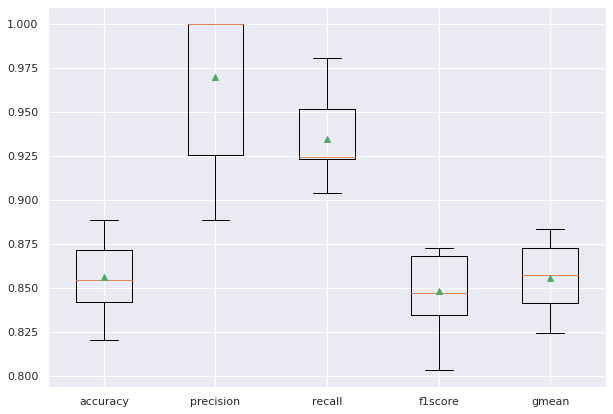

In [88]:
# BOXPLOT PARA CADA MÉTRICA
dataList = list()
sns.set(rc={'figure.figsize':(10,7)})
for i in diccionario.keys():
  data = diccionario[i]['test_score']
  dataList.append(data)

plt.boxplot(dataList, labels = listaNames, showmeans=True)
plt.show

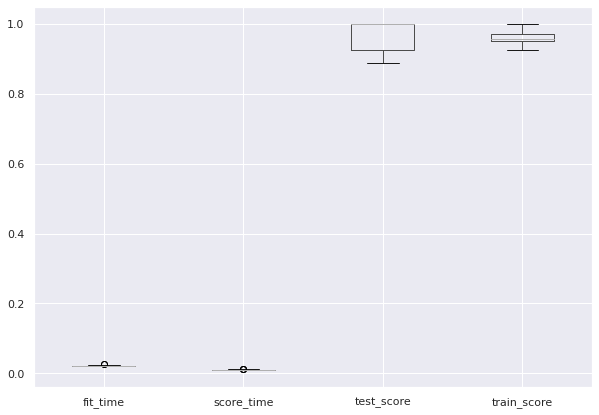

In [89]:
# MEJORES PARÁMETROS
SVM_final = svm.SVC(C=1, gamma=0.001, kernel='rbf')
SVM_pipe = Pipeline(steps=[("PreparaInfo", cols_Transformer),("model", SVM_final)])
SVM_score = cross_validate(SVM_pipe, Xtrain, Ytrain, scoring=make_scorer(precisionFunction), cv=SVM_kfold, return_train_score=True)

# DIAGRAMA DE CAJAS Y BIGOTES
sns.set(rc={'figure.figsize':(10,7)})
SVM_df = pd.DataFrame(SVM_score)
SVM_df.boxplot()

#**Ejercicio-6.**

In [90]:
def mi_LearningCurvePlot(train_sizes, train_scores, val_scores):
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(7,6))
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.1, color='blue')
    
    plt.plot(train_sizes, val_mean, color='red', marker='+', markersize=5, linestyle='--', label='Validation')
    plt.fill_between(train_sizes, val_mean + val_std, val_mean - val_std, alpha=0.1, color='red')
    
    plt.title('Curvas de Aprendizaje incrementando el tamaño de la muestra')
    plt.xlabel('Tamaño del conjunto de entrenamiento')
    plt.ylabel('Scoring')
    plt.grid()
    plt.legend(loc='lower left')
    plt.show()

In [91]:
def mi_ModeloYCurvas(Xin):

       modelo = svm.SVC()
       
       MODELS_pipe = Pipeline(steps=[("PreparaInfo", cols_Transformer),("model", modelo)])
       kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=7)

       delta_train_sz = np.linspace(0.1, 1.0, 20)

       tr_sizes, tr_scores, val_scores = learning_curve(n_jobs = -1,
                                                        estimator = MODELS_pipe ,    
                                                        X = Xin,
                                                        y = Ytrain.values.ravel(),
                                                        cv = kfold,
                                                        train_sizes = delta_train_sz)
       
       mi_LearningCurvePlot(tr_sizes, tr_scores, val_scores)

Curvas de aprendizaje del modelo SVC:


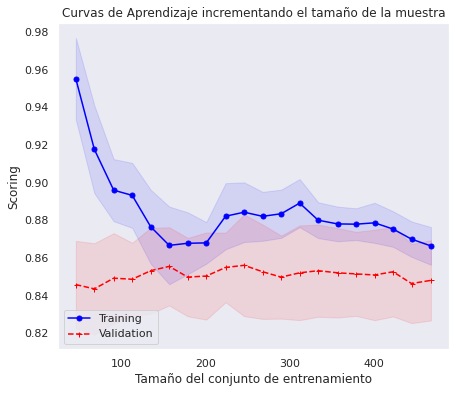

In [92]:
# MODELO DE SVC SIN MEJORES PARÁMETROS TRAIN

print('Curvas de aprendizaje del modelo SVC:')
mi_ModeloYCurvas(Xtrain)

In [93]:
def mi_ModeloYCurvastest(Xin):

       modelo = svm.SVC()
       
       MODELS_pipe = Pipeline(steps=[("PreparaInfo", cols_Transformer),("model", modelo)])
       kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=7)

       delta_train_sz = np.linspace(0.1, 1.0, 20)

       tr_sizes, tr_scores, val_scores = learning_curve(n_jobs = -1,
                                                        estimator = MODELS_pipe ,    
                                                        X = Xin,
                                                        y = Ytest.values.ravel(),
                                                        cv = kfold,
                                                        train_sizes = delta_train_sz)
       
       mi_LearningCurvePlot(tr_sizes, tr_scores, val_scores)

Curvas de aprendizaje del modelo SVC:


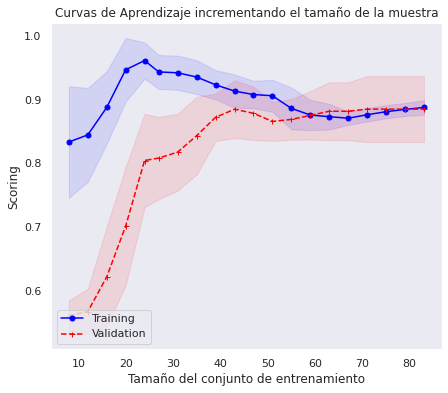

In [94]:
# MODELO DE SVC SIN MEJORES PARÁMETROS TEST

print('Curvas de aprendizaje del modelo SVC:')
mi_ModeloYCurvastest(Xtest)

In [95]:
def mi_ModeloYCurvas2(Xin):

       modelo2 = svm.SVC(C=1, gamma=0.001, kernel='rbf')
       
       MODELS2_pipe = Pipeline(steps=[("PreparaInfo", cols_Transformer),("model", modelo2)])
       kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=7)

       delta_train_sz = np.linspace(0.1, 1.0, 20)

       tr_sizes, tr_scores, val_scores = learning_curve(n_jobs = -1,
                                                        estimator = MODELS2_pipe ,    
                                                        X = Xin,
                                                        y = Ytrain.values.ravel(),
                                                        cv = kfold,
                                                        train_sizes = delta_train_sz)
       
       mi_LearningCurvePlot(tr_sizes, tr_scores, val_scores)

Curvas de aprendizaje del modelo SVC:


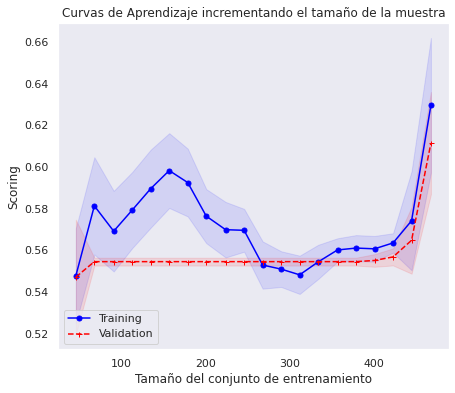

In [96]:
# MODELO DE SVC CON MEJORES PARÁMETROS TRAIN

print('Curvas de aprendizaje del modelo SVC:')
mi_ModeloYCurvas2(Xtrain)

In [98]:
def mi_ModeloYCurvas2test(Xin):

       modelo2 = svm.SVC(C=1, gamma=0.001, kernel='rbf')
       
       MODELS2_pipe = Pipeline(steps=[("PreparaInfo", cols_Transformer),("model", modelo2)])
       kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=7)

       delta_train_sz = np.linspace(0.1, 1.0, 20)

       tr_sizes, tr_scores, val_scores = learning_curve(n_jobs = -1,
                                                        estimator = MODELS2_pipe ,    
                                                        X = Xin,
                                                        y = Ytest.values.ravel(),
                                                        cv = kfold,
                                                        train_sizes = delta_train_sz)
       
       mi_LearningCurvePlot(tr_sizes, tr_scores, val_scores)

Curvas de aprendizaje del modelo SVC:


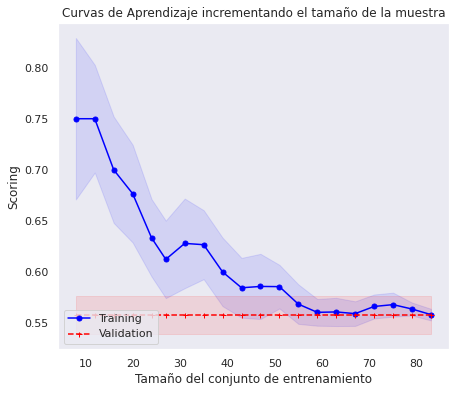

In [99]:
# MODELO DE SVC CON MEJORES PARÁMETROS TEST

print('Curvas de aprendizaje del modelo SVC:')
mi_ModeloYCurvas2test(Xtest)

#**Ejercicio-7.**

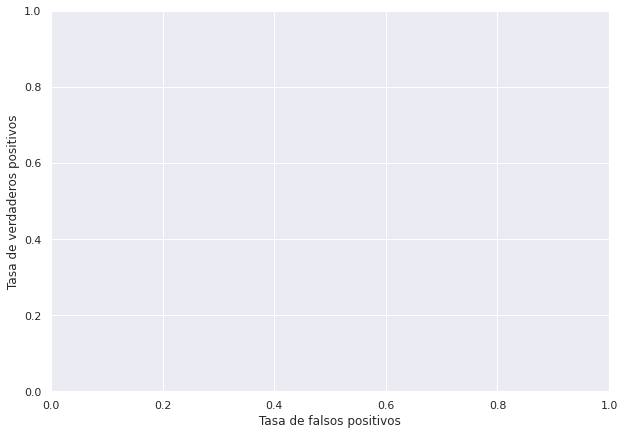

In [104]:
# TRAEMOS EL MODELO CON LOS MEJORES HIPERPARÁMETROS

SVM_final = svm.SVC(C=1, gamma=0.001, kernel='rbf')
SVM_pipe = Pipeline(steps=[("PreparaInfo", cols_Transformer),("model", SVM_final)])
SVM_score = cross_validate(SVM_pipe, Xtrain, Ytrain, scoring=make_scorer(precisionFunction), cv=SVM_kfold, return_train_score=True)

SVM_final.fit(Xtrain, Ytrain)

YtestSVM_hat = SVM_final.predict(Xtest)

#define métricas
fpr, tpr, _ = roc_curve(Ytest, YtestSVM_hat)

#create plt de la curva ROC
plt.ylabel(' Tasa de verdaderos positivos ')
plt.xlabel(' Tasa de falsos positivos ')
plt.show()

#**Ejercicio-8.**

In [ ]:
None

#**Ejercicio-9.**

In [ ]:
None

#**Ejercicio-10.**

In [ ]:
None

###**Fin de la Actividad de la semana 8.**